# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [3]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Data loading

In [5]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)

# Model creation

In [6]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential(
    [
        tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same', activation="relu",
                               input_shape=(28, 28, 1)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same', activation="relu"),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(NUM_CLASSES),

    ])

cnn_model.summary()
# your code start from here for stpe 2


# Build fully connected student.
fc_model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(784, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES),
    ])

fc_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0         
                                                                 
 dropout (Dropout)           (None, 3136)              0

# Teacher loss function

In [7]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, subclass_logits)


  return cross_entropy_loss_value

# Student loss function

In [8]:
##@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4. #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits/temperature)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels, ALPHA, DISTILLATION_TEMPERATURE):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True) # fc model

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False) # cnn_model
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits,
                      DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return ALPHA * distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value

# Train and evaluation

In [9]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))



def student_train_and_evaluate(model, compute_loss_fn, ALPHA, DISTILLATION_TEMPERATURE):
  """Perform training and evaluation for a student model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4

        loss_value = compute_loss_fn(images,labels, ALPHA, DISTILLATION_TEMPERATURE)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      num_correct += compute_num_correct(model,images,labels)[0]
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))

# Training models

In [10]:
# @title Default title text
# your code start from here for step 5

train_and_evaluate(cnn_model,compute_teacher_loss)




Epoch 1: 

Class_accuracy: 97.48%
Epoch 2: Class_accuracy: 98.44%
Epoch 3: Class_accuracy: 98.70%
Epoch 4: Class_accuracy: 98.82%
Epoch 5: Class_accuracy: 98.89%
Epoch 6: Class_accuracy: 99.03%
Epoch 7: Class_accuracy: 99.08%
Epoch 8: Class_accuracy: 99.15%
Epoch 9: Class_accuracy: 99.21%
Epoch 10: Class_accuracy: 99.19%
Epoch 11: Class_accuracy: 99.22%
Epoch 12: Class_accuracy: 99.31%


In [11]:
student_train_and_evaluate(fc_model,compute_student_loss, 0.7, 8)

Epoch 1: Class_accuracy: 97.28%
Epoch 2: Class_accuracy: 97.94%
Epoch 3: Class_accuracy: 98.33%
Epoch 4: Class_accuracy: 98.54%
Epoch 5: Class_accuracy: 98.65%
Epoch 6: Class_accuracy: 98.80%
Epoch 7: Class_accuracy: 98.69%
Epoch 8: Class_accuracy: 98.80%
Epoch 9: Class_accuracy: 98.84%
Epoch 10: Class_accuracy: 98.86%
Epoch 11: Class_accuracy: 98.90%
Epoch 12: Class_accuracy: 98.86%


# Test accuracy vs. tempreture curve

In [ ]:
# your code start from here for step 6
temperatures = [1, 2, 4, 16, 32, 64]

for temp in temperatures:
    print('\n For Distillation temperature:', temp)
    student_train_and_evaluate(fc_model, compute_student_loss, 0.5, temp)



 For Distillation temperature: 1
Epoch 1: Class_accuracy: 98.43%
Epoch 2: Class_accuracy: 98.52%
Epoch 3: Class_accuracy: 98.56%
Epoch 4: Class_accuracy: 98.64%
Epoch 5: Class_accuracy: 98.54%
Epoch 6: Class_accuracy: 98.62%
Epoch 7: Class_accuracy: 98.56%
Epoch 8: Class_accuracy: 98.55%
Epoch 9: Class_accuracy: 98.58%
Epoch 10: Class_accuracy: 98.51%
Epoch 11: Class_accuracy: 98.25%
Epoch 12: Class_accuracy: 98.38%

 For Distillation temperature: 2
Epoch 1: Class_accuracy: 98.55%
Epoch 2: Class_accuracy: 98.49%
Epoch 3: Class_accuracy: 98.53%
Epoch 4: Class_accuracy: 98.56%
Epoch 5: Class_accuracy: 98.51%
Epoch 6: Class_accuracy: 98.56%
Epoch 7: Class_accuracy: 98.17%
Epoch 8: Class_accuracy: 98.24%
Epoch 9: Class_accuracy: 98.47%
Epoch 10: Class_accuracy: 98.56%
Epoch 11: Class_accuracy: 98.48%
Epoch 12: Class_accuracy: 98.55%

 For Distillation temperature: 4
Epoch 1: Class_accuracy: 98.50%
Epoch 2: Class_accuracy: 98.43%
Epoch 3: Class_accuracy: 98.36%
Epoch 4: Class_accuracy: 98.

In [12]:
import tensorflow as tf

# Define a list of temperatures and alpha
temperatures = [1, 2, 4, 16, 32, 64]
alpha = 0.5
test_accuracy = []

# Define the student model architecture
# Function to train and evaluate the student model


# Iterate over temperatures and evaluate the model
for i, temp in enumerate(temperatures):

    student_train_and_evaluate(fc_model, compute_student_loss, alpha, temp)

    num_correct = 0
    num_total = builder.info.splits['test'].num_examples

    print('For Distillation temperature:', temp)

    for images, labels in mnist_test:
        num_correct += compute_num_correct(fc_model, images, labels)[0]

    class_accuracy = (num_correct / num_total) * 100
    print("Class accuracy: {:.2f}%".format(class_accuracy))
    test_accuracy.append(class_accuracy)


Epoch 1: Class_accuracy: 98.36%
Epoch 2: Class_accuracy: 98.38%
Epoch 3: Class_accuracy: 98.64%
Epoch 4: Class_accuracy: 98.65%
Epoch 5: Class_accuracy: 98.67%
Epoch 6: Class_accuracy: 98.61%
Epoch 7: Class_accuracy: 98.80%
Epoch 8: Class_accuracy: 98.67%
Epoch 9: Class_accuracy: 98.69%
Epoch 10: Class_accuracy: 98.66%
Epoch 11: Class_accuracy: 98.77%
Epoch 12: Class_accuracy: 98.75%
For Distillation temperature: 1
Class accuracy: 98.75%
Epoch 1: Class_accuracy: 98.73%
Epoch 2: Class_accuracy: 98.84%
Epoch 3: Class_accuracy: 98.86%
Epoch 4: Class_accuracy: 98.94%
Epoch 5: Class_accuracy: 98.81%
Epoch 6: Class_accuracy: 98.92%
Epoch 7: Class_accuracy: 98.83%
Epoch 8: Class_accuracy: 98.98%
Epoch 9: Class_accuracy: 98.88%
Epoch 10: Class_accuracy: 99.00%
Epoch 11: Class_accuracy: 99.03%
Epoch 12: Class_accuracy: 99.03%
For Distillation temperature: 2
Class accuracy: 99.03%
Epoch 1: Class_accuracy: 99.00%
Epoch 2: Class_accuracy: 98.87%
Epoch 3: Class_accuracy: 99.05%
Epoch 4: Class_accur

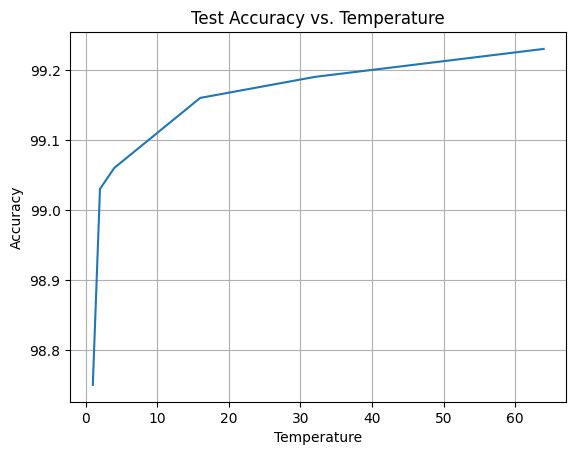

In [13]:
import matplotlib.pyplot as plt

# Plotting Test accuracy vs. temperature curve
plt.plot(temperatures, test_accuracy)
plt.title('Test Accuracy vs. Temperature')
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.grid(True)  # Add grid lines for better visualization
plt.show()


# Train student from scratch

In [14]:
# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES),
    ]
)

# your code start from here for step 7




def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)(labels, student_subclass_logits)

  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.04%
Epoch 2: Class_accuracy: 97.60%
Epoch 3: Class_accuracy: 97.70%
Epoch 4: Class_accuracy: 97.75%
Epoch 5: Class_accuracy: 98.01%
Epoch 6: Class_accuracy: 97.86%
Epoch 7: Class_accuracy: 97.96%
Epoch 8: Class_accuracy: 98.08%
Epoch 9: Class_accuracy: 97.90%
Epoch 10: Class_accuracy: 97.83%
Epoch 11: Class_accuracy: 98.07%
Epoch 12: Class_accuracy: 98.05%


# Comparing the teacher and student model (number of of parameters and FLOPs)

In [20]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
import numpy as np

def get_flops(model):
    # Define a forward pass as a tf.function
    @tf.function(input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])
    def forward_pass(inputs):
        return model(inputs)

    # Profile the forward pass to calculate FLOPs
    graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

    # Calculate FLOPs (floating-point operations)
    flops = graph_info.total_float_ops // 2  # Divide by 2 to account for multiply and accumulate as two ops

    # Calculate the number of model parameters
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_weights])
    non_trainable_params = np.sum([np.prod(v.shape) for v in model.non_trainable_weights])
    total_params = trainable_params + non_trainable_params

    return flops, trainable_params, non_trainable_params, total_params


In [21]:

#Calculating FLOPs and no. of parameters for the teacher model

flops_teacher,teacher_trainableParams,teacher_nonTrainableParams,teacher_totalParams = get_flops(cnn_model)
print('Flops for teacher model: {:,}'.format(flops_teacher))
print('Total Parameters for teacher model: {:,}'.format(teacher_totalParams))

Flops for teacher model: 4,278,853
Total Parameters for teacher model: 421,642.0


In [22]:
flops_student,student_trainableParams,student_nonTrainableParams,student_totalParams = get_flops(fc_model)
print('Flops for student model: {:,}'.format(flops_student))
print('Total Parameters for student model: {:,}'.format(student_totalParams))

Flops for student model: 1,237,941
Total Parameters for student model: 1,238,730.0


# Implementing the state-of-the-art KD algorithm

In [ ]:
# your code start from here for step 12


# XAI method to explain models

In [ ]:
# your code start from here for step 13
